# Hospital Pricing Transparency

This notebook utilizes data resulting from the CMS ruling requiring hospitals to disclose pricing data effective January 1, 2021. More information can be found regarding the tranparency rule here: https://www.cms.gov/hospital-price-transparency.

The purpose of this notebook is to look at several hospitals throughout Missouri and determine how DRG prices vary from hospital to hospital, and compare those to the Missouri and National Averages. Are they higher or lower than the state and national averages? In addition, this will combine the hospital data with Medicare data pulled for each hospital showing the Medicare revenue per day and per discharge for each hospital. Does the medicare information show the same patterns as the DRG pricing, with the same hospitals in the higher range and the same hospitals in the lower range?

### Loading Libraries and Creating Hospital List

In [21]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import os 

col_titles = ['Hospital','DRG','Price'] #Column titles used for formatting the hospital data
#List of hospitals used
hosp_list = ['Fitzgibbon Hospital','Nevada Regional Medical Center', 'Missouri Delta Medical Center','Saint Luke\'s East Hospital','St. Luke\'s Hospital Of Kansas City','Wright Memorial Hospital',
            'SoutheastHealth','St. Joseph Medical Center','Freeman Health System - Freeman West','North Kansas City Hospital']

In [22]:
os.chdir('C:\Source\hospital_pricing\Data')

In [23]:
def clean_currency(x):
    """(str)->(str)
    Cleans currency formatting and removes symbols and delimiters if value is a string.
    >>> clean_currency('$1,500')
    '1500'
    >>> clean_currency('1,500 ')
    '1500'
    """
    if isinstance(x,str):
        return(x.replace('$', '').replace(',', '').replace(' ',''))
    
    return(x)

def format_drg(series):
    """(series)->(series)
    Formats DRG column. Takes a series of DRG codes and format them consistently. Converts numeric types to strings and 
    formats DRG code to three digits adding zeros at the beginning where necessary. Removes MS at the beginning of the 
    value as well as the decimal and the zero following the decimal for string types.
    """
    new_series = []
    for item in series:
        if isinstance(item,str):
            if len(item)>3:
                if item[0]=='M':
                    item = item.replace('MS','')
                else:
                    item = item.strip().rstrip('.0')
            while len(item)<3:
                item = "0" + item
        elif isinstance(item,float):
            item = str(int(item))
            while len(item)<3:
                item = "0" + item
        else:
            item = str(item)
            while len(item)<3:
                item = "0" + item
        new_series.append(item)
    return pd.DataFrame(new_series)

### Load and Clean Hospital Data

There's a lot of variation within the data for each hospital, so this will require a decent amount of manual cleaning in addition to utilizing the functions defined above.

In [24]:
#Fitzgibbon Hospital
fitz = pd.read_csv("FitzgibbonHospital.csv")#read in file
fitz = fitz.drop([0,521,522]) #drop irrelevant rows
fitz['Hospital'] = hosp_list[0]#create column with hospital name
fitz.rename(columns = {'Average Charge':col_titles[2]}, inplace = True)#rename columns
fitz['Price'] = fitz['Price'].apply(clean_currency).astype(float).astype(int)#format column
fitz = fitz.groupby(['Hospital','DRG'],as_index = False).mean()#This takes the average price across the various payers

In [25]:
#Nevada Regional
nevada = pd.read_excel("NevadaRegional.xlsx", skiprows = 1294)#read in file
nevada = nevada.drop([0])#drop irrelevant rows
nevada.index[nevada['DRG'].str.match('CPT', na = False)] #locate where CPT codes begin
nevada = nevada.drop(nevada.iloc[64:].index) #start with index 65 since there is a blank row between DRG and CPT codes
nevada = nevada.rename(columns = {'Charges':'Price'})#rename columns
nevada['Hospital'] = hosp_list[1] #add hospital column
nevada = nevada[col_titles]#select columns

In [26]:
#MO Delta Medical
delta = pd.read_csv("MODeltaMedical.csv")#read in file
delta = delta.drop(delta.index[766:])#drop irrelevant rows
delta = pd.melt(delta,id_vars = ['MS-DRG '],value_vars = delta.iloc[:,9:16],var_name = 'Payer',value_name = 'Price')#pivot columns from wide to long
delta = delta.rename(columns = {'MS-DRG ':'DRG'})#rename columns
delta['Hospital'] = hosp_list[2]#add hospital column
delta = delta[col_titles]#select columns
delta['Price'] = delta['Price'].apply(clean_currency).astype('float') #format column
delta = delta.groupby(['Hospital','DRG'],as_index = False).mean() #This takes the average price across the various payers

In [27]:
#St Lukes East KC
stlukes_east = pd.read_csv("StLukesEastKC.csv",encoding = 'unicode_escape')#read in file
stlukes_east = stlukes_east[(stlukes_east['Charge Type']=='DRG')]#filter for DRG charge type
stlukes_east = stlukes_east.rename(columns = {'Procedure':'DRG','Gross Charge':'Price'})#rename columns
stlukes_east['Hospital'] = hosp_list[3]#add hospital column
stlukes_east = stlukes_east[col_titles]#select columns
stlukes_east = stlukes_east.groupby(['Hospital','DRG'], as_index = False).mean()#this selects columns and takes the average price across the various payers

C:\Users\jbrad\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
#St Lukes KC
stlukes = pd.read_csv("StLukesKC.csv",encoding ='unicode_escape')#read in file
stlukes = stlukes[(stlukes['Charge Type']== 'DRG')]#filter for DRG charge type
stlukes = stlukes.rename(columns = {'Procedure':'DRG','Gross Charge':'Price'})#rename columns
stlukes['Hospital'] = hosp_list[4]#add hospital column
stlukes = stlukes[col_titles]#select columns
stlukes = stlukes.groupby(['Hospital','DRG'],as_index = False).mean()#this takes the average price across the various payers

In [29]:
#Wright Memorial
wright = pd.read_csv("WrightMemorial.csv",encoding ='unicode_escape')#read in file
wright = wright[(wright['Charge Type']=='DRG')]#filter for DRG charge type
wright = wright.rename(columns = {'Procedure':'DRG','Gross Charge':'Price'})#rename columns
wright['Hospital'] = hosp_list[5]#add hospital column
wright = wright[col_titles]#select columns
wright = wright.groupby(['Hospital','DRG'], as_index = False).mean()#this takes the average price across the various payers

In [30]:
#Southeast Health
southeast = pd.read_excel("SoutheastHealth.xlsx", sheet_name = "DRG", skiprows = 4)#read in file
southeast['Hospital'] = hosp_list[6]#add hospital column
southeast = southeast.rename(columns = {'MS-DRG ':'DRG','Avg Charge\nPer Case':'Price'})#rename columns
southeast = southeast[col_titles]#select columns

In [31]:
#St Joseph Medical
stjoseph = pd.read_csv("StJosephMedical.csv")#read in file
stjoseph['Hospital'] = hosp_list[7]#add hospital column
stjoseph = stjoseph.rename(columns = {'MS-DRG':'DRG',' Average Charges ':'Price'})#rename columns
stjoseph = stjoseph[col_titles]#select columns

In [32]:
#Freeman Health
freeman = pd.read_csv("Freeman.csv")#read in file
freeman['Hospital'] = hosp_list[8]#add hospital column
freeman = freeman.rename(columns = {'DRG #':'DRG','CHARGE PER CASE':'Price'})#rename columns
freeman['DRG'] = freeman['DRG'].str.replace("DRG ",'')#takes DRG out of column values
freeman = freeman[col_titles]#select columns

In [33]:
#Meritas North KC
meritas = pd.read_excel("MeritasNorthKC.xlsx")#read in file
meritas = meritas[(meritas['LINE TYPE'] == 'DRG')]#filter for DRG charge type
meritas['Hospital'] = hosp_list[9]#add hospital column
meritas = meritas.rename(columns = {'CURRENT GROSS CHARGE':'Price'})#rename columns
meritas = meritas[col_titles]#select columns

### Combine Hospitals

In [34]:
#Combining dataframes
df = pd.concat([fitz,nevada,delta,stlukes_east,stlukes,wright,southeast,stjoseph,meritas,freeman],ignore_index = True)#combines all of the hospitals together
df['Hospital'].value_counts()#number of DRGs per hospital. MO Delta has the most, while Nevada has the least with only 64.

Missouri Delta Medical Center           766
SoutheastHealth                         759
St. Luke's Hospital Of Kansas City      737
Saint Luke's East Hospital              715
North Kansas City Hospital              635
Freeman Health System - Freeman West    549
St. Joseph Medical Center               373
Wright Memorial Hospital                161
Fitzgibbon Hospital                     130
Nevada Regional Medical Center           64
Name: Hospital, dtype: int64

### MO and National DRG Average Charges

In [35]:
#Grabbing MO and National charges and pay columns to use as a benchmark
delta_p = pd.read_csv("MODeltaMedical.csv")#read in file
delta_p = delta_p.drop(delta_p.index[766:])#dropping irrelevant rows
bench = delta_p[['MS-DRG ','MO State Avg Chgs (4% Increase)','National Avg Chgs (4% Increase)']].fillna(0).astype(int)#selecting and formatting columns
bench = bench.rename(columns = {'MS-DRG ':'DRG','MO State Avg Chgs (4% Increase)':'MO Charge','National Avg Chgs (4% Increase)':'National Charge'})#renaming columns
bench['DRG'] = format_drg(bench['DRG'])#format DRG column
bench.head()

,DRG,MO Charge,National Charge
0,001,819862,1126639
1,002,0,619736
2,003,514451,681575
3,004,298339,379128
4,005,345594,606805


### Medicare Information

This is medicare information obtained for hospitals throughout Missouri in 2018.

In [36]:
#use pandas to read html table
medicare = pd.read_html("https://dexur.com/usa/state-mo/")[0]#read in table
medicare['Medicare Discharges'] = medicare.iloc[:,6]#add column
medicare['Hospital'] = medicare['Hospital Name']#add column

#format and select the columns
medicare['Medicare Revenue'] = medicare['Medicare Revenue'].apply(clean_currency).fillna(0).astype(int)#formatting column
medicare['Medicare Revenue Per Day'] = medicare['Medicare Revenue Per Day'].apply(clean_currency).fillna(0).astype(int)#formatting column
medicare['Medicare Revenue Per Discharge']=(medicare['Medicare Revenue']/medicare['Medicare Discharges']).astype(int)#creates column for medicare revenue per discharge
medicare = medicare[['Hospital','Medicare Revenue Per Day','Medicare Revenue Per Discharge']]#selects columns 
medicare.head()

,Hospital,Medicare Revenue Per Day,Medicare Revenue Per Discharge
0,Barnes Jewish Hospital,2762,16659
1,Mercy Hospital Springfield,2218,10605
2,Mercy Hospital St. Louis,2203,11545
3,Cox Medical Centers,1973,10091
4,Mercy Hospital South,1720,8642


### Merge Dataframes

This merges the medicare data with the hospitals.

In [37]:
total_df = pd.merge(df,medicare,on = 'Hospital',how='left')#combines Medicare data with the hospital data
total_df['Price'] = total_df['Price'].apply(clean_currency).fillna(0).astype(float).astype(int)#formatting column
total_df['DRG'] = format_drg(total_df['DRG'])#format DRG column
total_df.head()

,Hospital,DRG,Price,Medicare Revenue Per Day,Medicare Revenue Per Discharge
0,Fitzgibbon Hospital,056,10027,1857,6532
1,Fitzgibbon Hospital,064,10996,1857,6532
2,Fitzgibbon Hospital,065,22210,1857,6532
3,Fitzgibbon Hospital,066,8675,1857,6532
4,Fitzgibbon Hospital,069,20473,1857,6532


This merges the MO and National DRG average charges with the rest of the data.

In [38]:
total_data = total_df.merge(bench,how='left',on='DRG')#combines the MO and National average DRG charges with the hospital and medicare data
total_data.iloc[:,5:] = total_data.iloc[:,5:].fillna(0).astype(int)#format columns
total_data.dtypes #checking datatypes

Hospital                          object
DRG                               object
Price                              int32
Medicare Revenue Per Day           int32
Medicare Revenue Per Discharge     int32
MO Charge                          int32
National Charge                    int32
dtype: object

In [39]:
total_data.isnull().sum() #checking for missing values

Hospital                          0
DRG                               0
Price                             0
Medicare Revenue Per Day          0
Medicare Revenue Per Discharge    0
MO Charge                         0
National Charge                   0
dtype: int64

In [60]:
total_data.shape

(4889, 7)

In [40]:
total_data.head()#first five rows

,Hospital,DRG,Price,Medicare Revenue Per Day,Medicare Revenue Per Discharge,MO Charge,National Charge
0,Fitzgibbon Hospital,056,10027,1857,6532,51071,65303
1,Fitzgibbon Hospital,064,10996,1857,6532,54428,66638
2,Fitzgibbon Hospital,065,22210,1857,6532,35059,40455
3,Fitzgibbon Hospital,066,8675,1857,6532,27126,32044
4,Fitzgibbon Hospital,069,20473,1857,6532,30831,34721


In [41]:
total_data.describe().astype(int)#descriptive statistics

,Price,Medicare Revenue Per Day,Medicare Revenue Per Discharge,MO Charge,National Charge
count,4889,4889,4889,4889,4889
mean,53823,1988,10013,54141,74496
std,62852,308,2336,55829,72181
min,0,1374,6054,0,0
25%,18196,1736,8658,25865,35229
50%,36484,1890,9723,40631,55812
75%,65711,2394,10574,67061,86659
max,1119691,2509,14600,819862,1126639


### Visualizations

<AxesSubplot:title={'center':'Mean'}, ylabel='Hospital'>

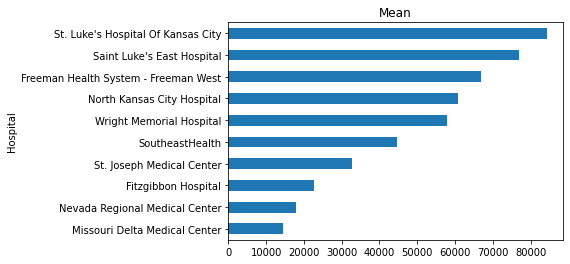

In [42]:
#bar plot showing the average price per hospital
total_data.groupby(['Hospital'])['Price'].mean().sort_values().plot(kind='barh', title='Mean')

<AxesSubplot:title={'center':'Median'}, ylabel='Hospital'>

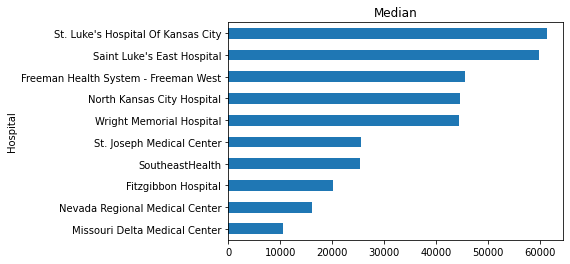

In [43]:
#bar plot showing the median price per hospital
#the median prices are a little lower overall compared to the mean and the only hospital to switch were St. Joseph and Southeast Health
total_data.groupby(['Hospital'])['Price'].median().sort_values().plot(kind='barh',title='Median')

[(0.0, 300000.0)]

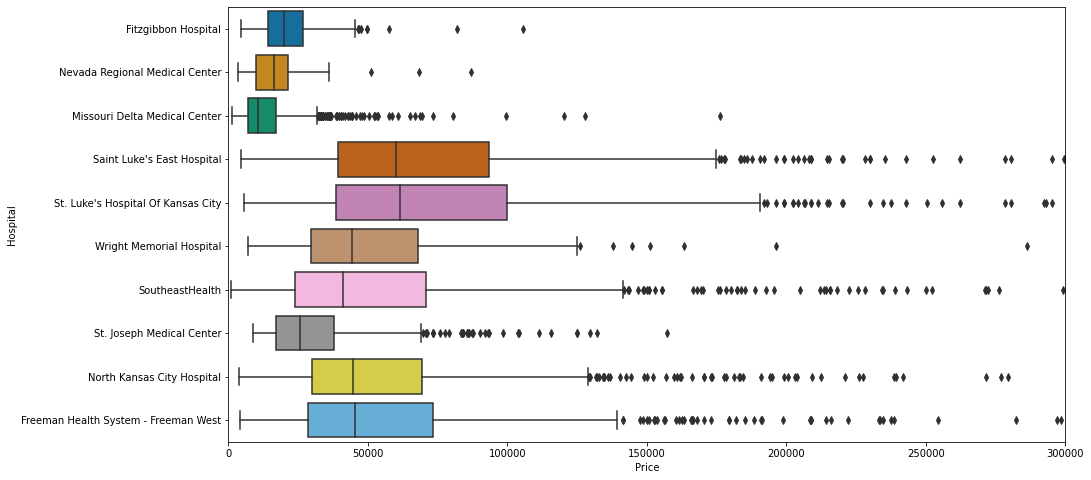

In [44]:
#boxplot grouped by hospital
#Fitzgibbon, Nevada Regional, MO Delta and St Joseph are left skewed while both of the St Lukes hospitals are the most right skewed of the group
plt.figure(figsize=(15,8))
data = total_data[total_data['Price']>0]
sns.boxplot(y= 'Hospital',x='Price',data=data, palette='colorblind', orient="h").set(xlim=(0,300000))

[(0.0, 100000.0)]

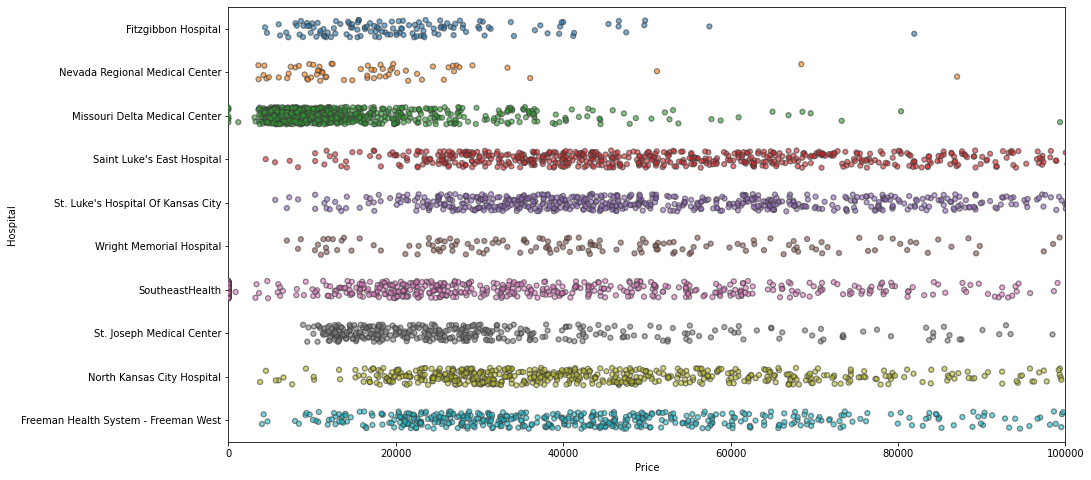

In [45]:
#stripplot grouped by hospital
#MO Delta is concentrated below 20000
plt.figure(figsize=(15,8))
sns.stripplot(y = "Hospital", x="Price",data=total_data,jitter=0.20, alpha=0.6,linewidth=1.25).set(xlim=(0,100000))

[(0.0, 10000.0)]

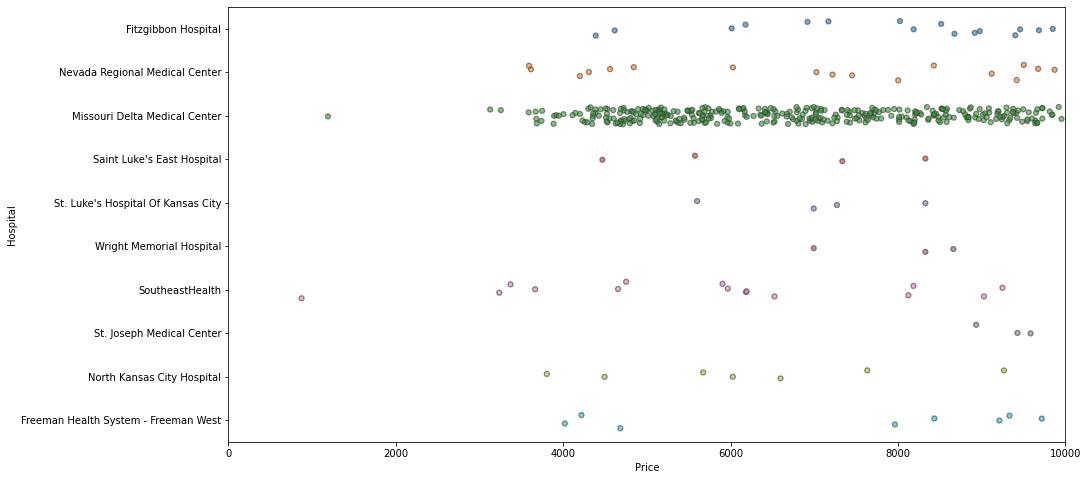

In [46]:
#stripplot grouped by hospital and filtered between 0 and 10000
#this highlights a little more clearly how concentrated MO Delta is
ten_k = total_data[(total_df['Price']<10000)&(total_data['Price']>0)]#filter for between 0 and 10000
plt.figure(figsize=(15,8))
sns.stripplot(y = "Hospital", x="Price",data=ten_k,jitter=0.20, alpha=0.6,linewidth=1.25).set(xlim=(0,10000))

[(0.0, 100000.0)]

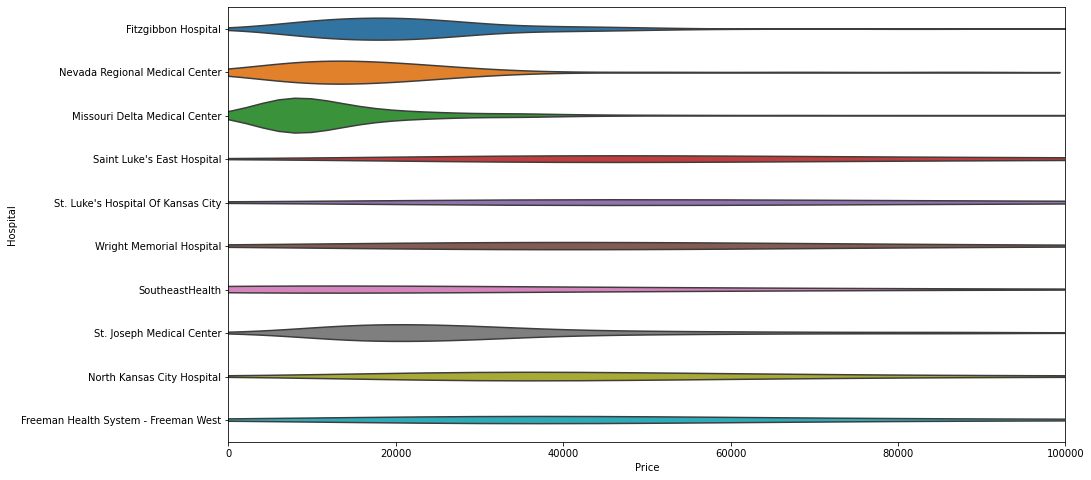

In [47]:
#violin plot - Missouri Delta, Nevada and Fitzgibbon all are heavily concentrated below 20000
plt.figure(figsize=(15,8))
sns.violinplot(y='Hospital',x='Price',data=total_data, inner=None,scale="area").set(xlim=(0,100000))

### Comparing Hospitals to the MO Average Charge Per DRG

This will look at the two DRG codes that have the highest price over the MO average charge. 

In [48]:
compare_mo = total_data.groupby('DRG').agg({'Price':np.mean,'MO Charge':np.mean})#aggregate the hospital prices grouped by DRG and created mean column and column for the MO charge
compare_mo = compare_mo[compare_mo['MO Charge']>0]#selecting values greater than zero for MO charge column
compare_mo['MO Diff'] = (compare_mo['Price']-compare_mo['MO Charge'])#creating column for the difference of the hospital average versus MO average
compare_mo = compare_mo[compare_mo['MO Diff']>0].sort_values(by='MO Diff', ascending = False).astype(int)#selecting values and sorting for MO diff column
len(compare_mo) #number of DRGs that are priced higher for our hospital group average versus the MO average

198

In [49]:
top_two = compare_mo.head(2)#taking the 2 with the highest difference
top_two

,Price,MO Charge,MO Diff
DRG,,,
255,121397,53500,67897
665,140049,74067,65982


<AxesSubplot:xlabel='Price', ylabel='Hospital'>

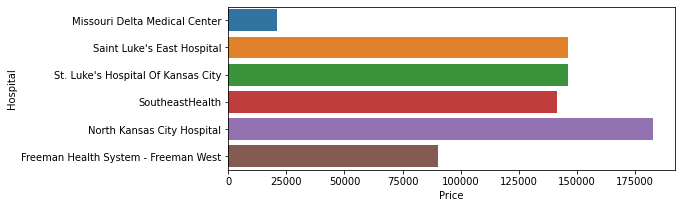

In [50]:
#barplot for DRG 255
#MO Delta is significantly cheaper in addition to Freeman Health
data = total_data[total_data['DRG']=='255']
plt.figure(figsize=(8,3))
sns.barplot(y='Hospital',x='Price',data=data)

<AxesSubplot:xlabel='Price', ylabel='Hospital'>

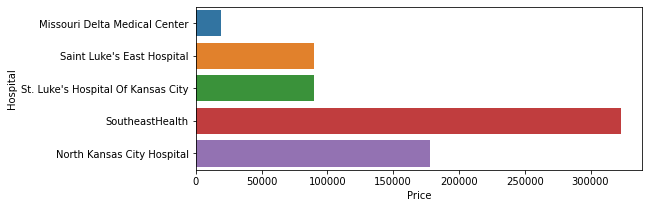

In [51]:
#barplot for DRG 665
#there are large differences between pricing here. From ~ 25000 for MO Delta to ~325000 for Southeast Health
data = total_data[total_data['DRG']=='665']
plt.figure(figsize=(8,3))
sns.barplot(y='Hospital',x='Price',data=data)

### Comparing Hospitals to the National Average Charge Per DRG

This will look at the two DRG codes that have the highest price over the national average charge. 

In [52]:
compare_us = total_data.groupby('DRG').agg({'Price':np.mean,'National Charge':np.mean})#aggregate the hospital prices grouped by DRG and created mean column column for the national average charge
compare_us = compare_us[compare_us['National Charge']>0]#selecting values greater than zero for the national charge column
compare_us['National Diff'] = (compare_us['Price']-compare_us['National Charge'])#creating column for the difference of the hospital average versus national average
compare_us = compare_us[compare_us['National Diff']>0].sort_values(by='National Diff', ascending = False).astype(int)#selecting values and sorting for national diff column
len(compare_us) #number of DRGs that are priced higher for our hospital group average versus the national average

31

In [53]:
top_two = compare_us.head(2)#taking the 2 with the highest difference
top_two

,Price,National Charge,National Diff
DRG,,,
969,329663,208554,121109
255,121397,85881,35516


Since DRG 255 is in the top two again, we will not do another bar plot since that was done in the above section.

<AxesSubplot:xlabel='Price', ylabel='Hospital'>

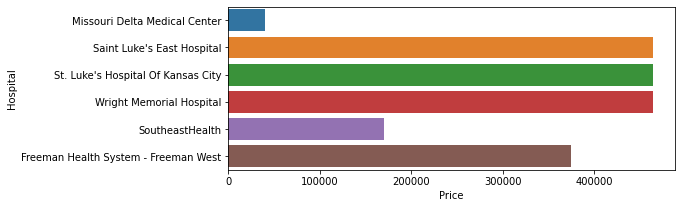

In [54]:
#barplot for DRG 969
#MO Delta and Southeast are both significantly cheaper than the rest
data = total_data[total_data['DRG']=='969']
plt.figure(figsize=(8,3))
sns.barplot(y='Hospital',x='Price',data=data)

<AxesSubplot:ylabel='Density'>

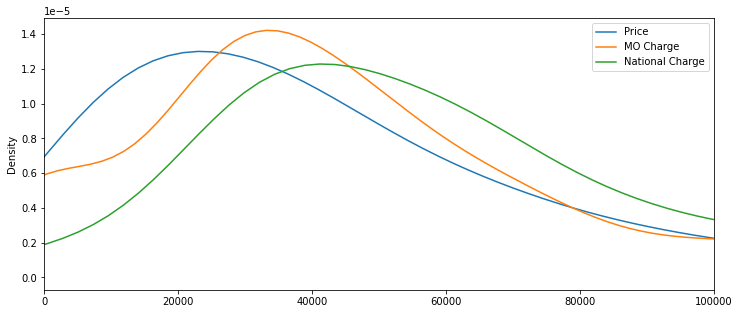

In [55]:
#KDE plot showing the consolidated price column for all hospitals compared to the MO and national average prices
#This hospital group is overall cheaper than both the MO and national prices
total_data[['Price','MO Charge','National Charge']].plot.kde(xlim=(0,100000),figsize=(12,5))

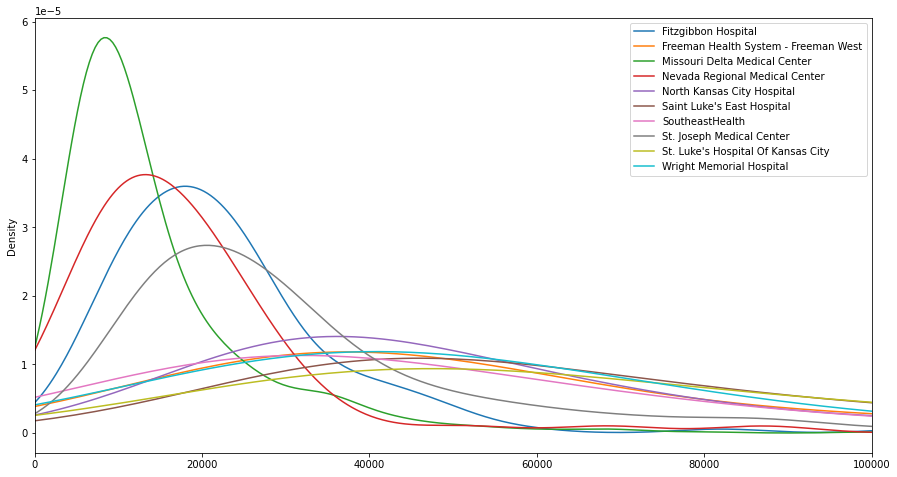

In [56]:
#KDE plot per hospital
#as we saw above MO Delta, Fitzgibbon, Nevada Regional and St Joseph are all pulled to the left and cheaper than the rest of the group
data = total_data[total_data['Price']>0]#filter for values greater than zero
plt.figure(figsize=(15,8))
data.groupby('Hospital')['Price'].plot.kde(xlim=(0,100000),linewidth=1.5)
plt.legend()

### Comparing Medicare Information

This section shows the overall medicare revenue per day and the revenue per discharge for Medicare inpatient visits in 2018 for each hospital. The two barcharts show a little different outcome than we saw above for the DRG codes where the same few hospitals were consistently on the lower end, and the same were consistently on the higher end. Both of the St Luke's hospitals were very close to each other in most of the other visuals, but are very different on both of these charts. Fitzgibbon was consistently on the low end for DRG pricing but is closer to the middle of the group for revenue per day, though does drop down closer to the bottom for revenue per discharge

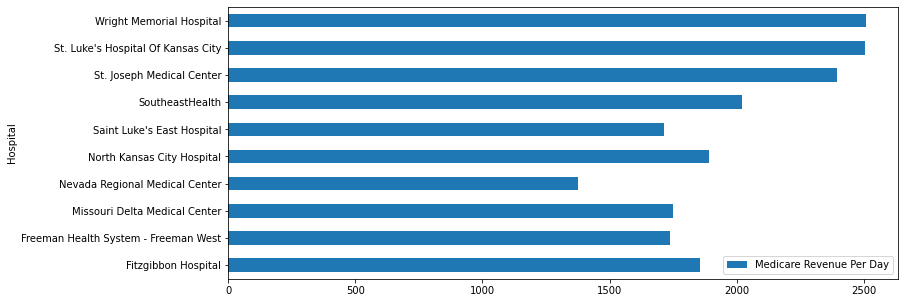

In [57]:
#bar plot showing medicare revenue per day by hospital
df =total_data.groupby('Hospital')[['Medicare Revenue Per Day']].mean().plot(kind = 'barh', figsize=(12,5))

<AxesSubplot:ylabel='Hospital'>

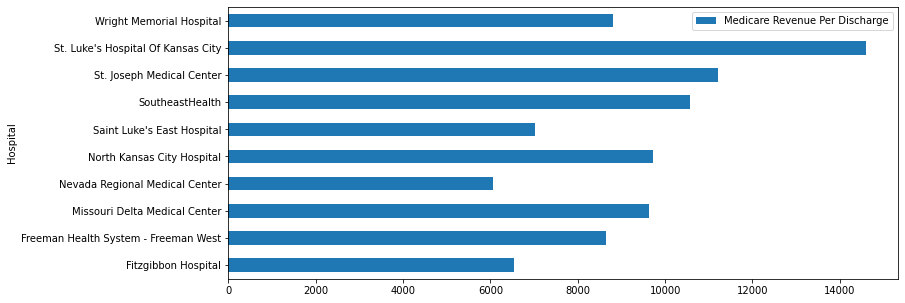

In [58]:
#bar plot showing medicare revenue per discharge
total_data.groupby('Hospital')[['Medicare Revenue Per Discharge']].mean().plot(kind = 'barh', figsize=(12,5))

### Conclusion

There is a lot of variation in pricing between the ten hospitals, with four hospitals (MO Delta, Fitzgibbon, Nevada Regional and St Joseph) consistently cheaper than the rest of the group. Overall, the group of hospitals are cheaper than both the MO and national average charges, though there are almost 200 codes above the MO average and close to 30 for the national average. For the Medicare revenue, as mentioned above, there is some variation from the patterns seen for the DRG pricing. 